C:\Users\zayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\zayan/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:05<00:00, 2.48MB/s]


Epoch 1/15 - Train Acc: 0.8024, Val Acc: 0.9031
Epoch 2/15 - Train Acc: 0.8877, Val Acc: 0.9184
Epoch 3/15 - Train Acc: 0.8957, Val Acc: 0.9174
Epoch 4/15 - Train Acc: 0.9033, Val Acc: 0.9232
Epoch 5/15 - Train Acc: 0.9095, Val Acc: 0.9288
Epoch 6/15 - Train Acc: 0.9096, Val Acc: 0.9314
Epoch 7/15 - Train Acc: 0.9066, Val Acc: 0.9314
Epoch 8/15 - Train Acc: 0.9104, Val Acc: 0.9312
Epoch 9/15 - Train Acc: 0.9105, Val Acc: 0.9414
Epoch 10/15 - Train Acc: 0.9090, Val Acc: 0.9341
Epoch 11/15 - Train Acc: 0.9097, Val Acc: 0.9208
Epoch 12/15 - Train Acc: 0.9076, Val Acc: 0.9373
Epoch 13/15 - Train Acc: 0.9118, Val Acc: 0.9406
Epoch 14/15 - Train Acc: 0.9272, Val Acc: 0.9445
Epoch 15/15 - Train Acc: 0.9275, Val Acc: 0.9469


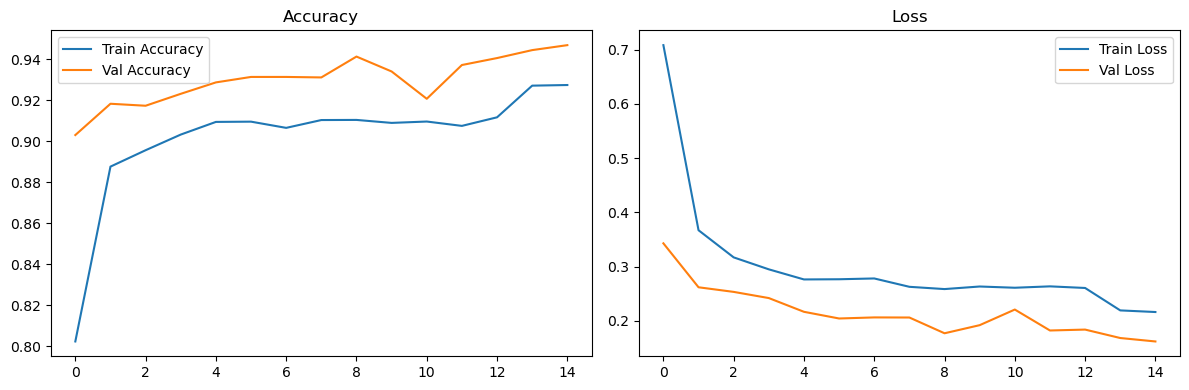

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      1.00      0.98       202
                     Pepper__bell___healthy       0.98      1.00      0.99       259
                      Potato___Early_blight       0.99      1.00      0.99       207
                       Potato___Late_blight       0.92      0.94      0.93       187
                           Potato___healthy       0.93      0.93      0.93        27
                      Tomato_Bacterial_spot       0.97      0.97      0.97       416
                        Tomato_Early_blight       0.85      0.78      0.82       204
                         Tomato_Late_blight       0.93      0.90      0.91       387
                           Tomato_Leaf_Mold       0.89      0.96      0.92       183
                  Tomato_Septoria_leaf_spot       0.97      0.90      0.93       342
Tomato_Spider_mites_Two_spotted_spider_mite       0.93      0.93

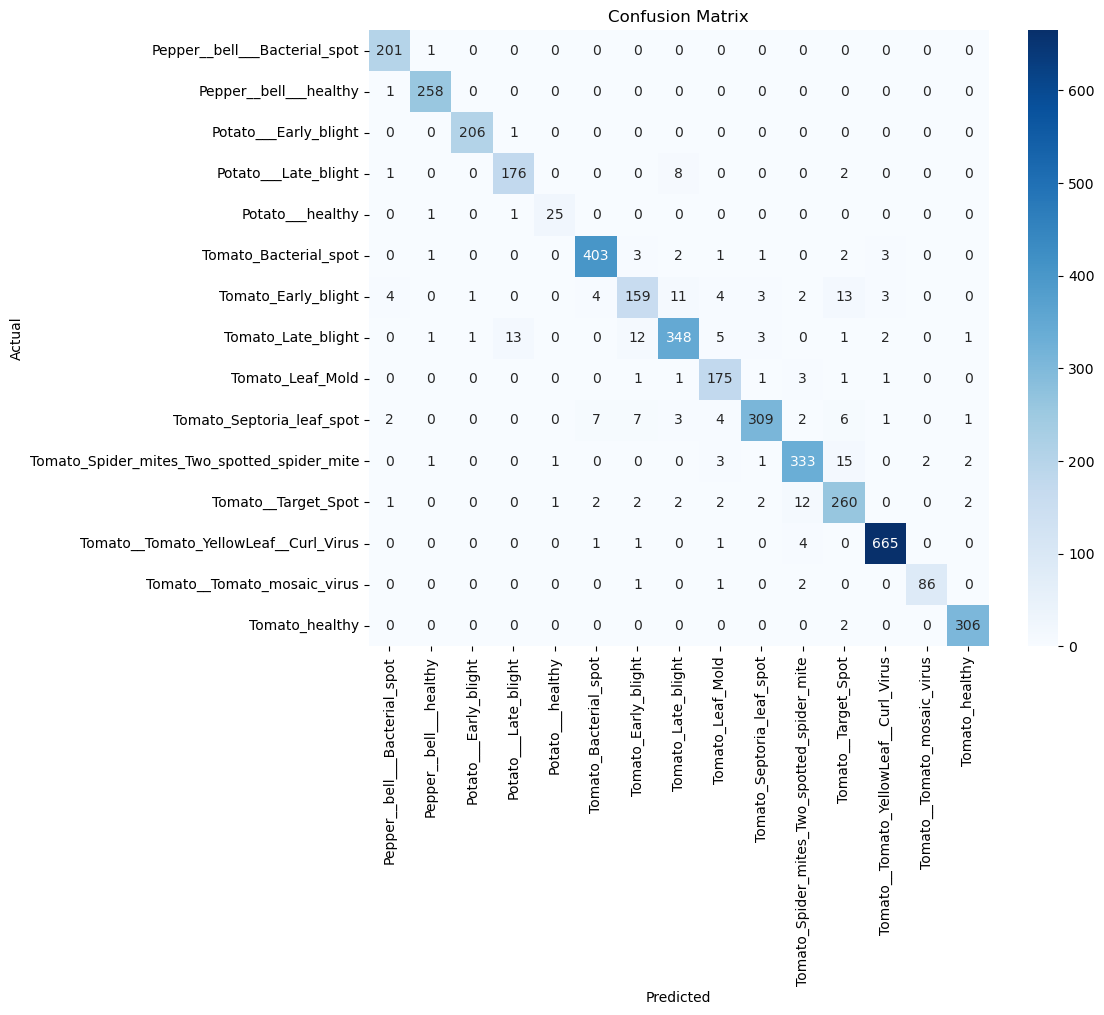

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dataset path
data_dir = r"C:\Users\zayan\Downloads\ann\PlantVillage"

# Constants
IMG_HEIGHT = 224  # MobileNetV2 expects 224x224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load data
train_data = datasets.ImageFolder(os.path.join(data_dir), transform=train_transform)
num_classes = len(train_data.classes)

# Split dataset
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, num_classes)
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc.append(correct / len(train_loader.dataset))
    train_loss.append(running_loss / len(train_loader))

    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    val_acc.append(correct / len(val_loader.dataset))
    val_loss.append(running_loss / len(val_loader))

    scheduler.step(val_loss[-1])

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Save model
torch.save(model.state_dict(), "mobilenetv2_plantleaf_finetuned.pth")

# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Classification Report & Confusion Matrix
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
